# Evaluating Model Performance
We will evaluate and compare the performance of the models using the following metrics:
- Accuracy
- Precision
- Recall


In [13]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd

In [14]:
# os.chdir(r'C:\Users\david\projects\University\gemstone-classifier\src')
curr_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(curr_dir, os.pardir))


### Load the training results

In [15]:
results = {}
top_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Top-3 Accuracy', 'Top-5 Accuracy'])

for dataset in os.listdir('../mod/'):
    for file in os.listdir(f'../mod/{dataset}/'):
        if file.endswith('.csv'):
            model = os.path.splitext(file)[0]
            print(f'Processing {model}...')
            history = pd.read_csv(f'../mod/{dataset}/{file}')
            results[model + ' ' + dataset] = history
            top_results = pd.concat([top_results, pd.DataFrame({'Model': model,
                                                                'Dataset': dataset,
                                                                'Accuracy': history['val_accuracy'].max(),
                                                                'Top-3 Accuracy': history['val_top_3_accuracy'].max(),
                                                                'Top-5 Accuracy': history['val_top_5_accuracy'].max()}, index=[0])])
top_results[top_results['Dataset'] == 'images_cropped_augmented_2000' ].sort_values(by='Accuracy', ascending=False)


Processing MobileNet...
Processing OwnModel...
Processing OwnModelRegularized...
Processing ResNet50...
Processing VGG16...
Processing MobileNet...
Processing VGG16...
Processing MobileNet...
Processing OwnModel...
Processing ResNet50...
Processing VGG16...
Processing MobileNet...
Processing OwnModel...
Processing ResNet50...
Processing VGG16...
Processing OwnModelRegularized...


C:\Users\david\AppData\Local\Temp\ipykernel_18824\3516126414.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  top_results = pd.concat([top_results, pd.DataFrame({'Model': model,


,Model,Dataset,Accuracy,Top-3 Accuracy,Top-5 Accuracy
0,OwnModel,images_cropped_augmented_2000,0.538392,0.830663,0.900718
0,VGG16,images_cropped_augmented_2000,0.514250,0.796970,0.876597
0,MobileNet,images_cropped_augmented_2000,0.447379,0.715229,0.808144
0,ResNet50,images_cropped_augmented_2000,0.212088,0.413109,0.538115


In [16]:
top_results[top_results['Dataset'] == 'first_run_gempundit_2022_cropped_augmented_2000' ].sort_values(by='Accuracy', ascending=False)


,Model,Dataset,Accuracy,Top-3 Accuracy,Top-5 Accuracy
0,ResNet50,first_run_gempundit_2022_cropped_augmented_2000,0.563305,0.877011,0.924228
0,OwnModelRegularized,first_run_gempundit_2022_cropped_augmented_2000,0.538542,0.854727,0.912685
0,VGG16,first_run_gempundit_2022_cropped_augmented_2000,0.516501,0.845589,0.906756
0,OwnModel,first_run_gempundit_2022_cropped_augmented_2000,0.507606,0.828044,0.892461
0,MobileNet,first_run_gempundit_2022_cropped_augmented_2000,0.456476,0.755577,0.833609


### Plot the metrics for each model over the epochs

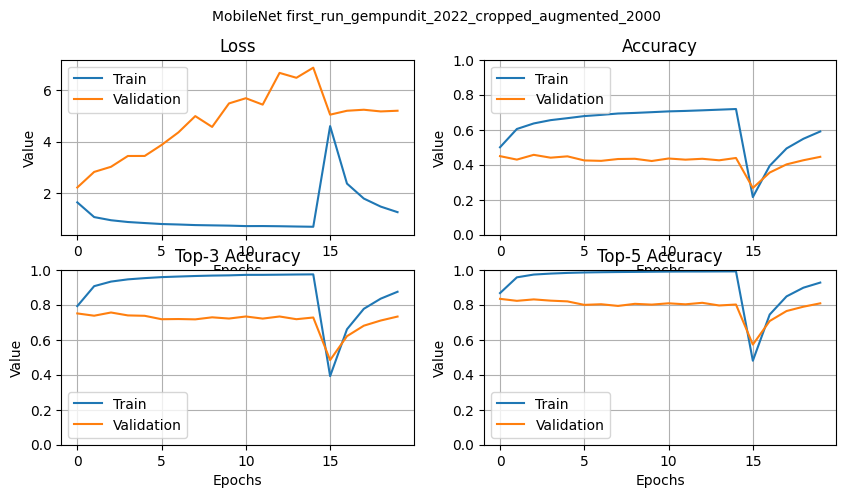

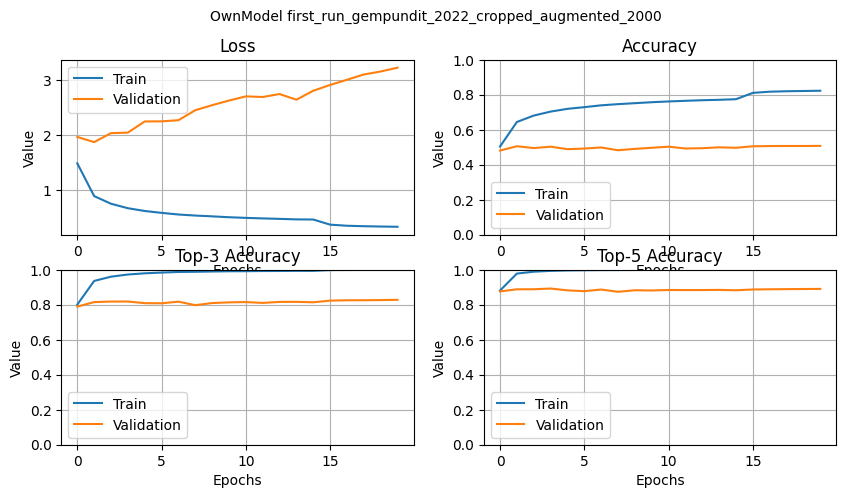

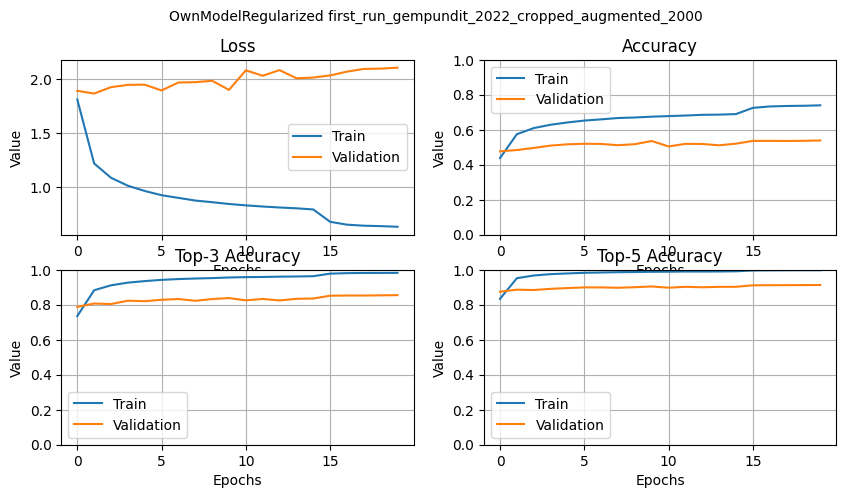

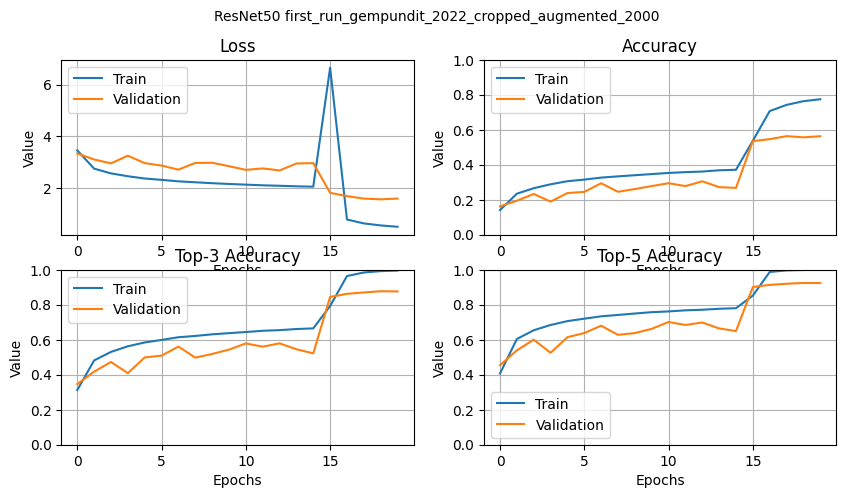

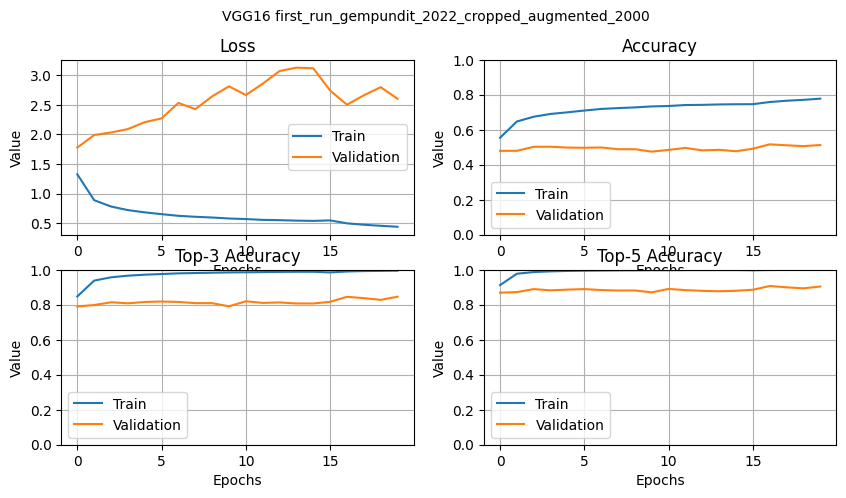

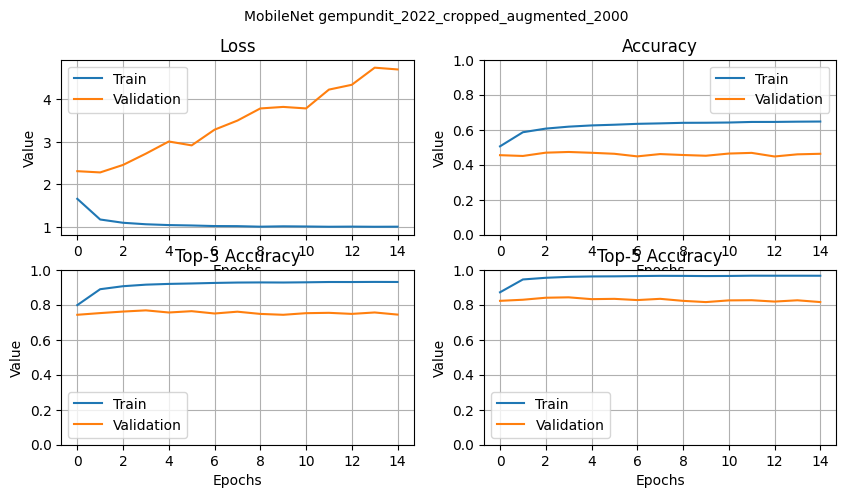

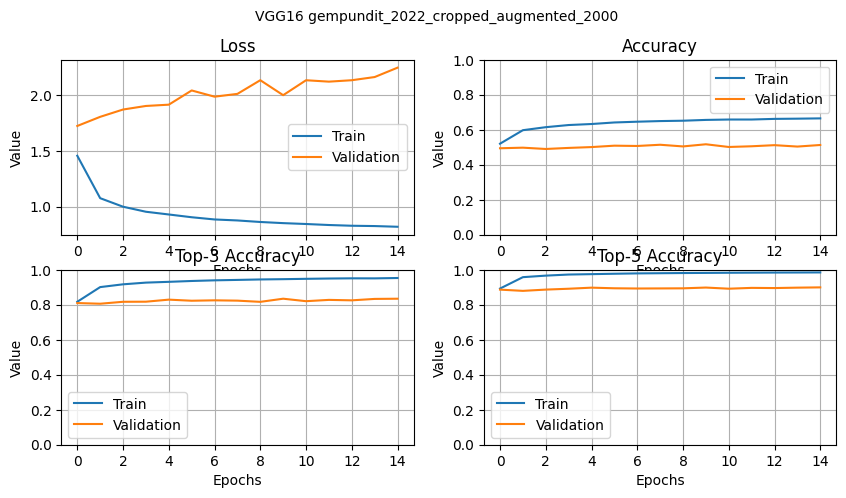

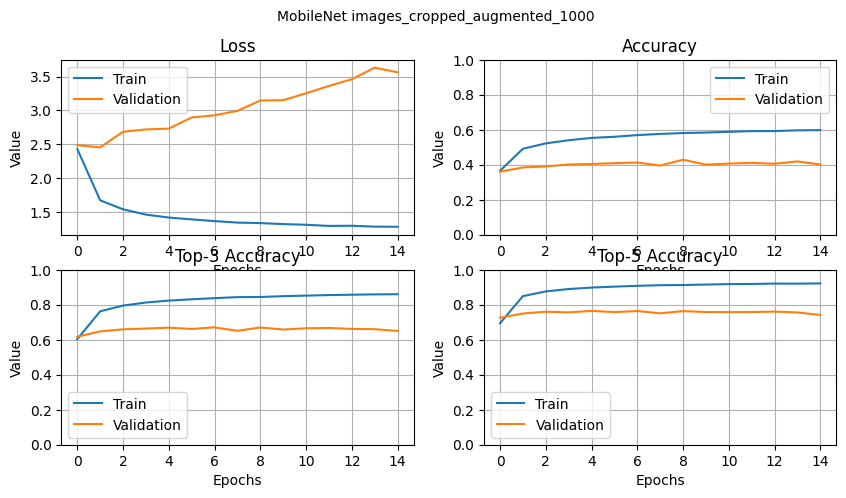

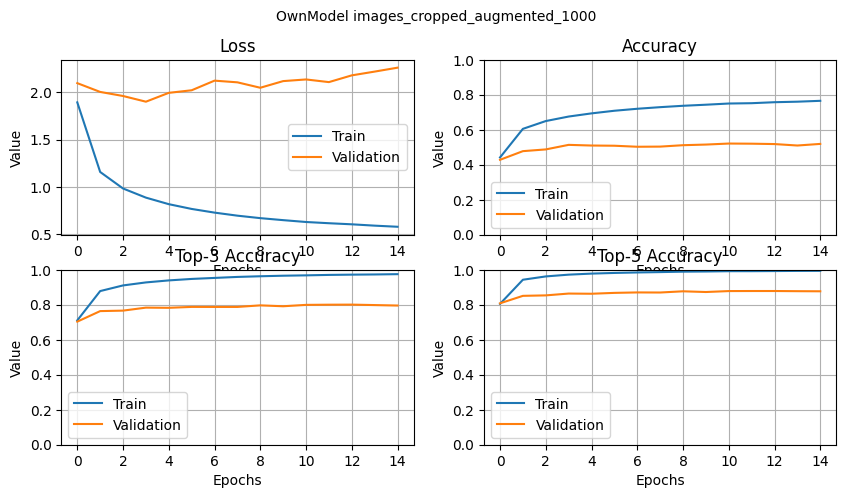

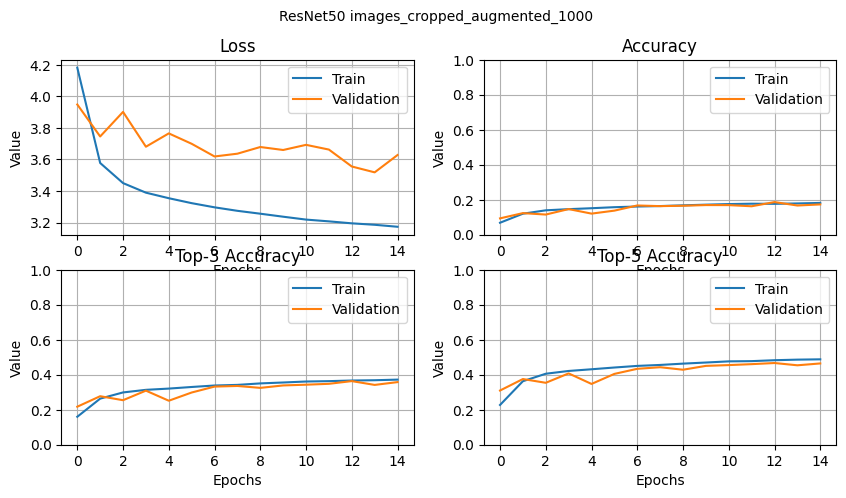

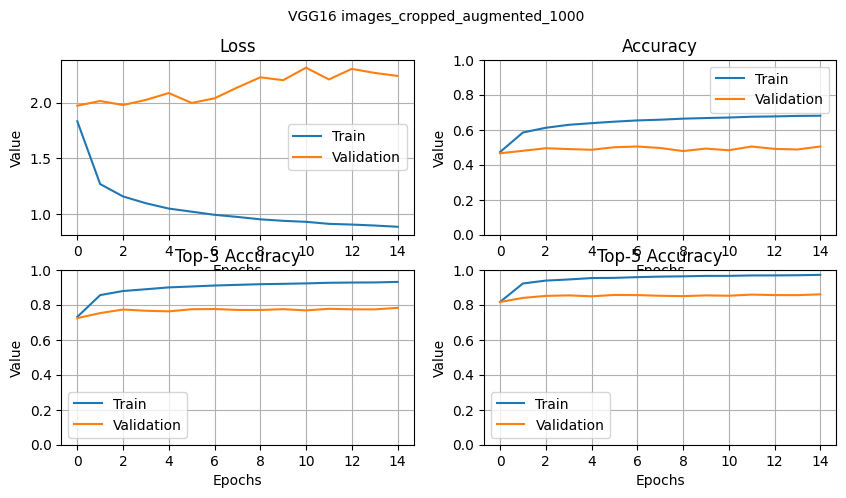

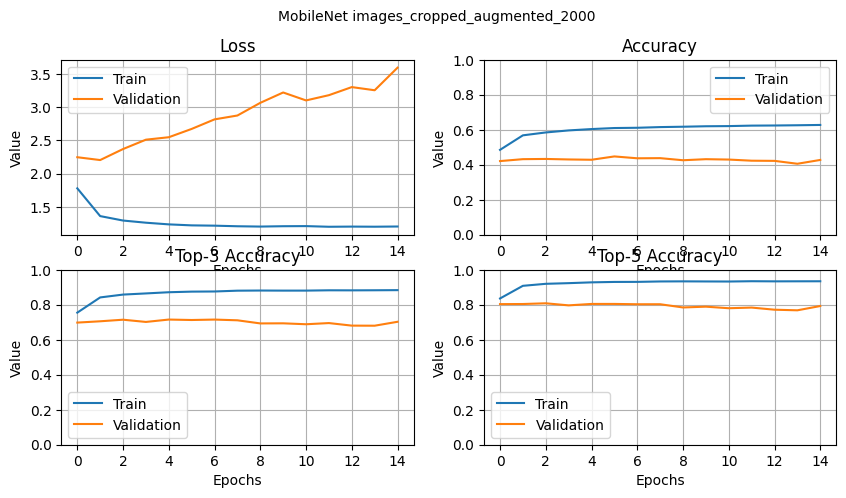

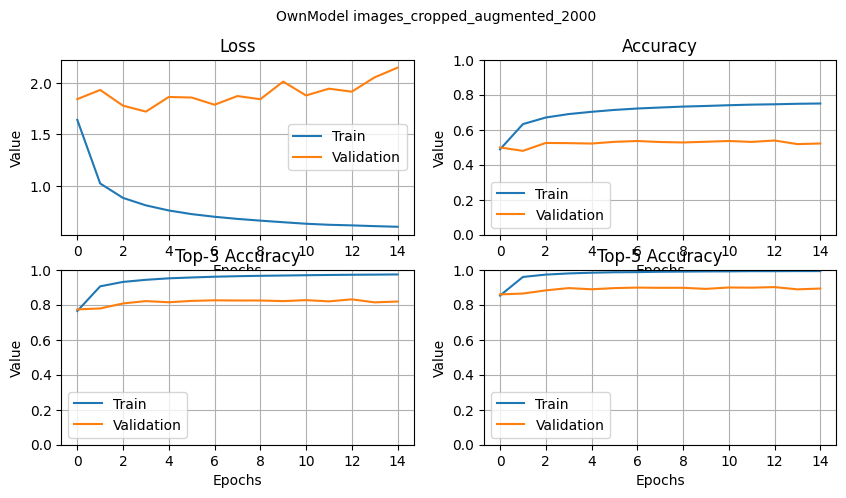

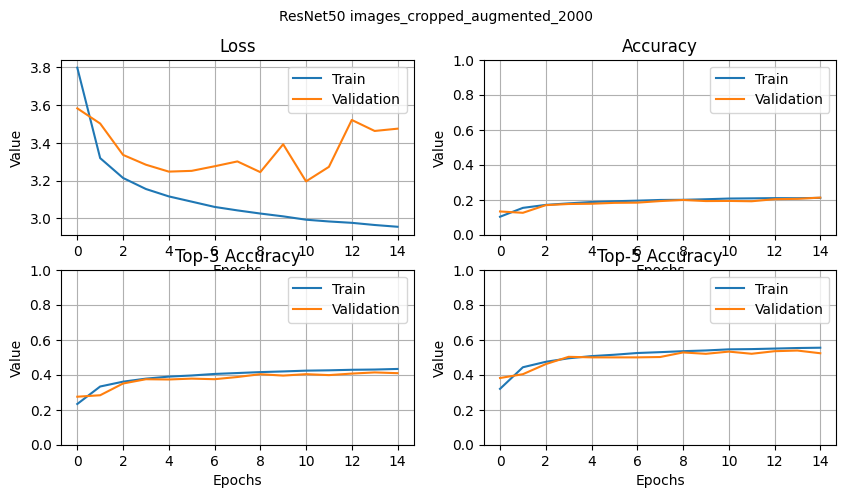

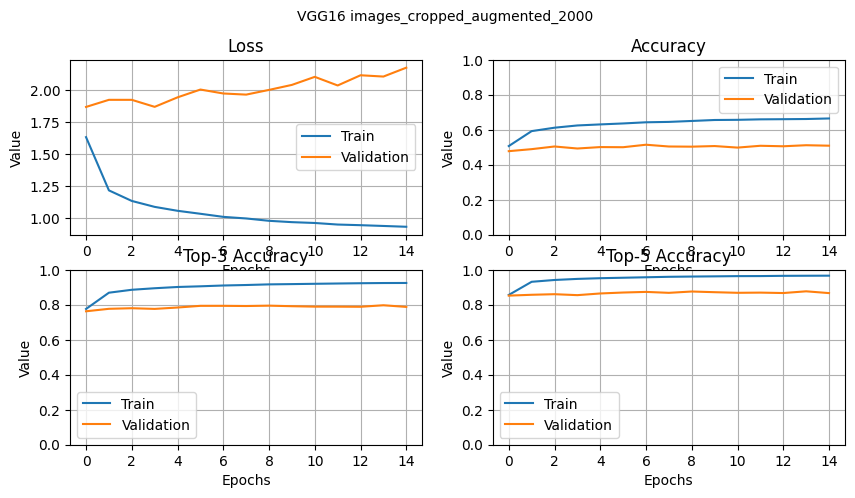

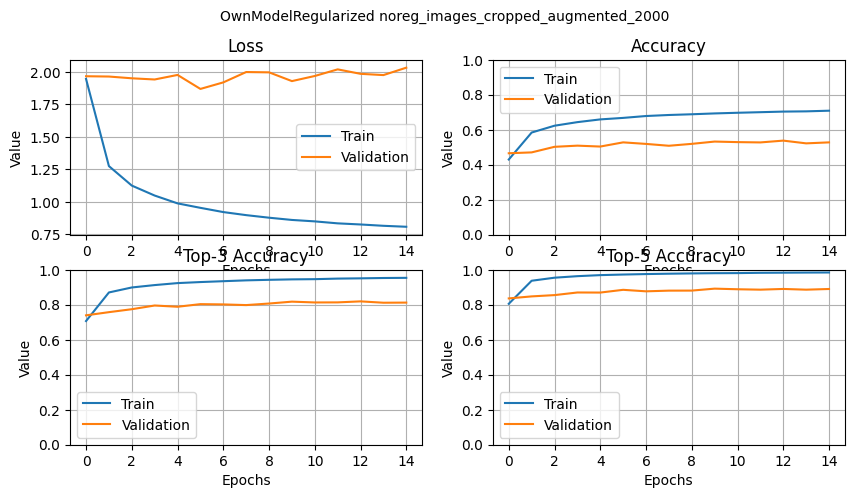

In [21]:
# Define a function to plot the metrics with adjusted y-axis limits for accuracy plots
def plot_metrics_adjusted(history, title):
    fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    fig.suptitle(title, fontsize=10)

    # Loss
    axs[0, 0].plot(history['loss'], label='Train')
    axs[0, 0].plot(history['val_loss'], label='Validation')
    axs[0, 0].set_title('Loss')
    axs[0, 0].legend()

    # Accuracy
    axs[0, 1].plot(history['accuracy'], label='Train')
    axs[0, 1].plot(history['val_accuracy'], label='Validation')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].set_ylim([0, 1])
    axs[0, 1].legend()

    # Top-3 Accuracy
    axs[1, 0].plot(history['top_3_accuracy'], label='Train')
    axs[1, 0].plot(history['val_top_3_accuracy'], label='Validation')
    axs[1, 0].set_title('Top-3 Accuracy')
    axs[1, 0].set_ylim([0, 1])
    axs[1, 0].legend()

    # Top-5 Accuracy
    axs[1, 1].plot(history['top_5_accuracy'], label='Train')
    axs[1, 1].plot(history['val_top_5_accuracy'], label='Validation')
    axs[1, 1].set_title('Top-5 Accuracy')
    axs[1, 1].set_ylim([0, 1])
    axs[1, 1].legend()

    for ax in axs.flat:
        ax.set(xlabel='Epochs', ylabel='Value')
        ax.grid()

for model, history in results.items():
    plot_metrics_adjusted(history, model)


### Compare the models for the used Top-K-Accuracy

C:\Users\david\AppData\Local\Temp\ipykernel_18824\3995393637.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


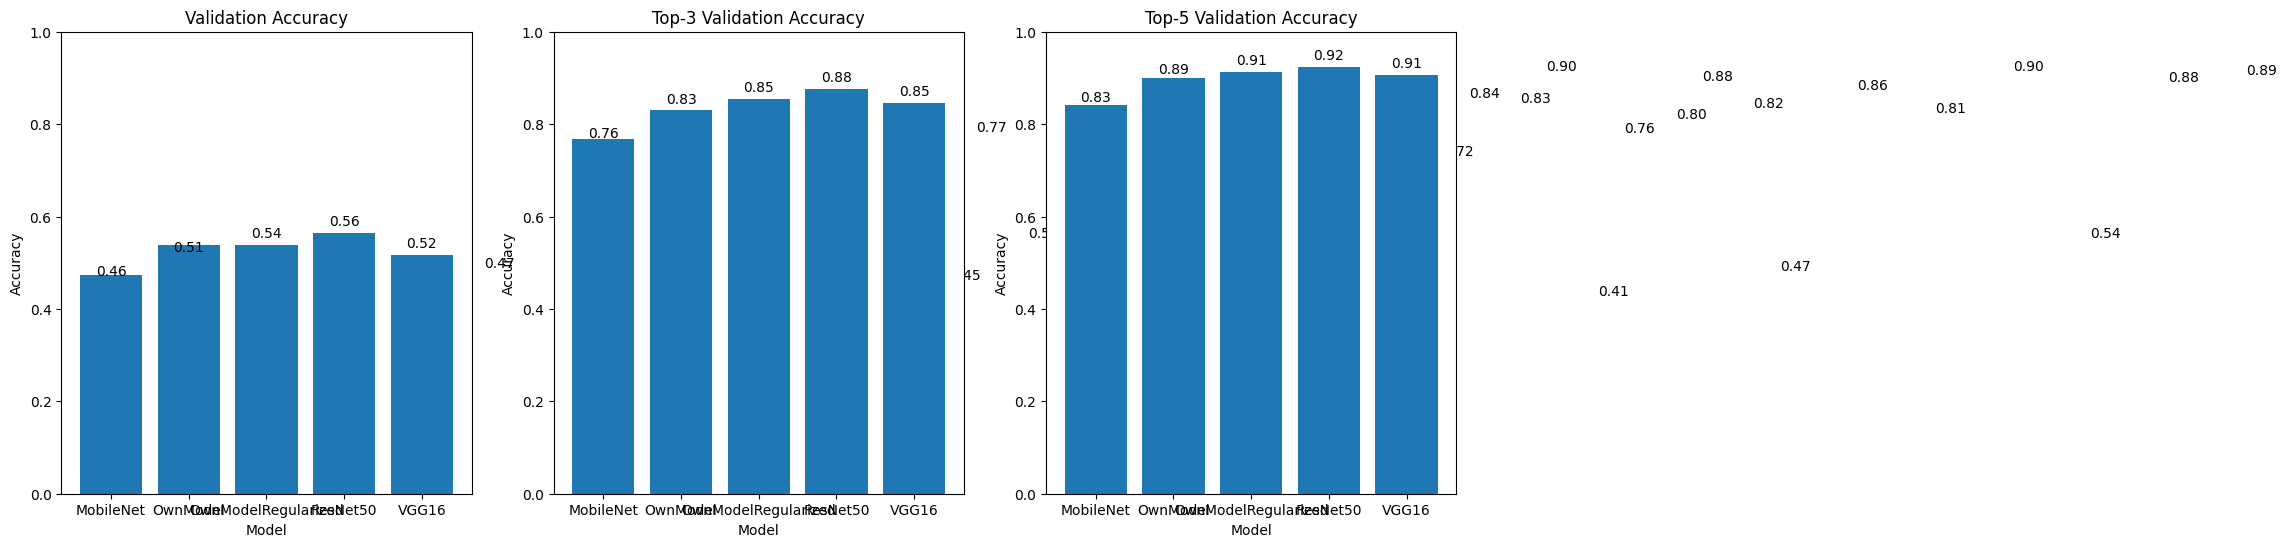

In [18]:
# Function to create bar plots for each Top-k accuracy
def create_bar_plot(y_values, title, y_label, ax):
    ax.bar(top_results['Model'], y_values)
    ax.set_title(title)
    ax.set_ylim([0, 1])
    ax.set_xlabel('Model')
    ax.set_ylabel(y_label)
    for i, v in enumerate(y_values):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Accuracy plot
create_bar_plot(top_results['Accuracy'], 'Validation Accuracy', 'Accuracy', axs[0])

# Top-3 Accuracy plot
create_bar_plot(top_results['Top-3 Accuracy'], 'Top-3 Validation Accuracy', 'Accuracy', axs[1])

# Top-5 Accuracy plot
create_bar_plot(top_results['Top-5 Accuracy'], 'Top-5 Validation Accuracy', 'Accuracy', axs[2])

plt.tight_layout()
plt.show()

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import numpy as np

# Load the model
models_path = r'C:\Users\david\projects\University\gemstone-classifier\mod\first_run_gempundit_2022_cropped_augmented_2000'
data_dir = r'C:\Users\david\projects\University\gemstone-classifier\dat\gempundit_2022_cropped_augmented_2000'

models = []
for file in os.listdir(os.path.normpath(models_path)):
    if file.endswith('llr.h5'):
        models.append(file)

# Parameters (replace these with your values)
target_size = (224, 224)  # Example target size
batch_size = 32
validation_split = 0.2

# Image data generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

# Load data
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=False  # Important for evaluation
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Important for evaluation
)

# Evaluate the model
val_steps = val_data.samples // batch_size

true_classes = val_data.classes
true_classes = true_classes[:val_steps * batch_size]  # Aligning the true labels length with the prediction length

index_to_class = {v: k for k, v in val_data.class_indices.items()}

results = {}
for model_name in models:
    print(f'Processing {model_name}...')
    model = load_model(models_path + '/' + model_name)

    predictions = model.predict(val_data, steps=val_steps)

    predicted_probs = predictions[:len(true_classes)]  # Aligning the prediction length with true labels
    predicted_labels = np.argmax(predicted_probs, axis=1)

    results[model_name] = {
        'predicted_probs': predicted_probs,
        'predicted_labels': predicted_labels
    }


Found 164657 images belonging to 99 classes.
Found 41150 images belonging to 99 classes.
Processing MobileNet_FT_llr.h5...
1285/1285 [==============================] - 62s 48ms/step
Processing OwnModelRegularized_FT_llr.h5...
1285/1285 [==============================] - 46s 35ms/step
Processing OwnModel_FT_llr.h5...
1285/1285 [==============================] - 49s 38ms/step
Processing ResNet50_FT_llr.h5...
1285/1285 [==============================] - 102s 78ms/step
Processing VGG16_FT_llr.h5...
1285/1285 [==============================] - 98s 74ms/step


### Calculate Top-K-Accuracy

In [24]:
# Custom function to calculate top-k accuracy
def top_k_accuracy(true_labels, pred_labels, k):
    top_k_preds = np.argsort(pred_labels, axis=1)[:, -k:]
    match_array = np.any(top_k_preds == np.array(true_labels)[:, None], axis=1)
    top_k_accuracy = np.mean(match_array)
    return top_k_accuracy


top_k_acc = {}
for model, result in results.items():
    predicted_probs = result['predicted_probs']
    predicted_labels = result['predicted_labels']
    top_k_acc[model] = {}
    for k in [1, 3, 5]:
        ac = top_k_accuracy(true_classes, predicted_probs, k)
        top_k_acc[model][f'top_{k}_accuracy'] = ac

In [25]:
print(top_k_acc)

{'MobileNet_FT_llr.h5': {'top_1_accuracy': 0.4453550583657588, 'top_3_accuracy': 0.7321741245136186, 'top_5_accuracy': 0.8077821011673152}, 'OwnModelRegularized_FT_llr.h5': {'top_1_accuracy': 0.5389348249027237, 'top_3_accuracy': 0.8546206225680933, 'top_5_accuracy': 0.9126215953307393}, 'OwnModel_FT_llr.h5': {'top_1_accuracy': 0.5079523346303502, 'top_3_accuracy': 0.8279182879377431, 'top_5_accuracy': 0.8903696498054474}, 'ResNet50_FT_llr.h5': {'top_1_accuracy': 0.5631566147859922, 'top_3_accuracy': 0.8757538910505837, 'top_5_accuracy': 0.9238083657587549}, 'VGG16_FT_llr.h5': {'top_1_accuracy': 0.5129377431906614, 'top_3_accuracy': 0.845476653696498, 'top_5_accuracy': 0.9038667315175097}}


In [26]:
# NEW
# https://www.evidentlyai.com/classification-metrics/accuracy-precision-recall

# accuracy = (TP + TN) / (TP + TN + FP + FN) 
# precision = TP / (TP + FP) 
# 1 is always predicitng target class correctly
# recall = TP / (TP + FN)
# 1 if all instances of target found in data 

import numpy as np
import matplotlib.pyplot as plt

num_classes = np.max(true_classes) + 1  # Assuming class labels are 0-indexed
# Parameters for top-k and last-k
k = 10

for model, result in results.items():
    accuracy = []
    precision = []
    recall = []
    predicted_labels = result['predicted_labels']
    for class_id in range(num_classes):
        TP = np.sum((predicted_labels == class_id) & (true_classes == class_id))
        FP = np.sum((predicted_labels == class_id) & (true_classes != class_id))
        TN = np.sum((predicted_labels != class_id) & (true_classes != class_id))
        FN = np.sum((predicted_labels != class_id) & (true_classes == class_id))
        
        single_accuracy = (TP + TN) / (TP + TN + FP + FN)  if (TP + TN + FP + FN) > 0 else 0 
        single_precision = TP / (TP + FP) if (TP +  FP) > 0 else 0
        single_recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        accuracy.append(single_accuracy)
        precision.append(single_precision)
        recall.append(single_recall)
        
    accuracy_array = np.array(accuracy)
    precision_array = np.array(precision)
    recall_array = np.array(recall)

    results[model]['accuracy'] = accuracy_array
    results[model]['precision'] = precision_array
    results[model]['recall'] = recall_array

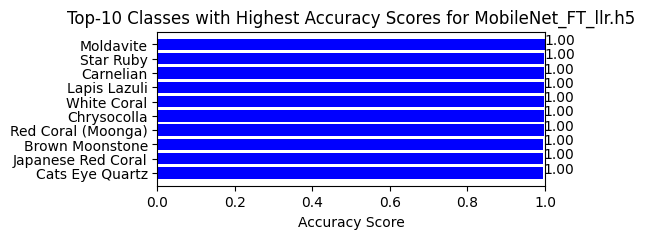

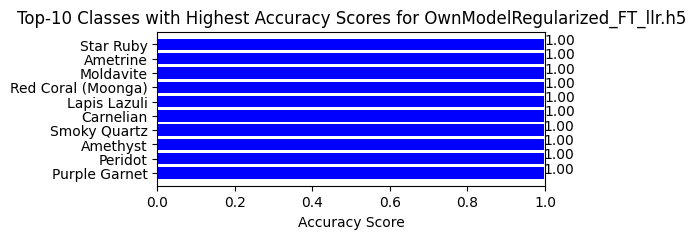

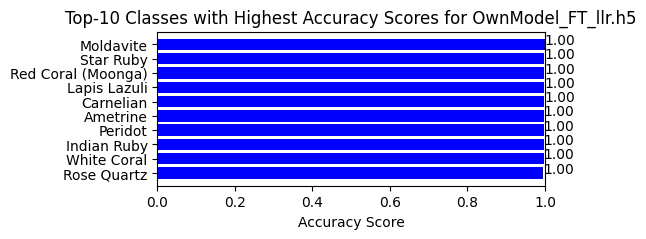

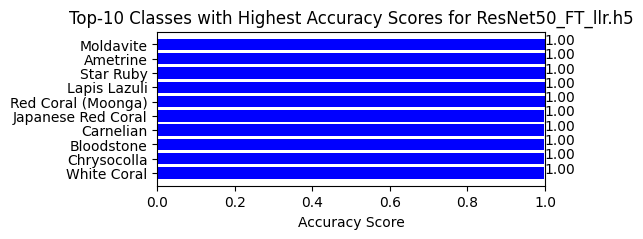

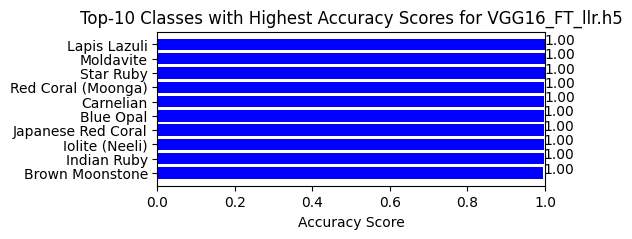

In [27]:
# Top-K Accuracy
for i, (model, result) in enumerate(results.items()):
    top_k_indices = np.argsort(result['accuracy'])[-k:][::-1]
    top_k_ious = result['accuracy'][top_k_indices]
    top_k_class_names = [index_to_class[i] for i in top_k_indices]
    plt.figure(figsize=(5, 2))
    plt.barh(top_k_class_names, top_k_ious, color='blue')
    # show the values on the bars
    for index, value in enumerate(top_k_ious):
        plt.text(value, index, f'{value:.2f}', ha='left', size=10)
    plt.xlabel('Accuracy Score')
    plt.xlim([0, 1])
    plt.title(f'Top-{k} Classes with Highest Accuracy Scores for {model}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
    plt.show()

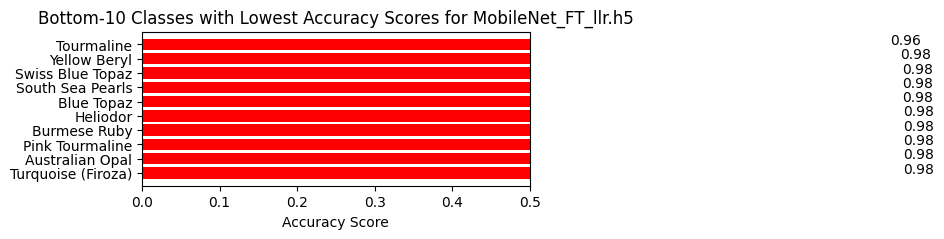

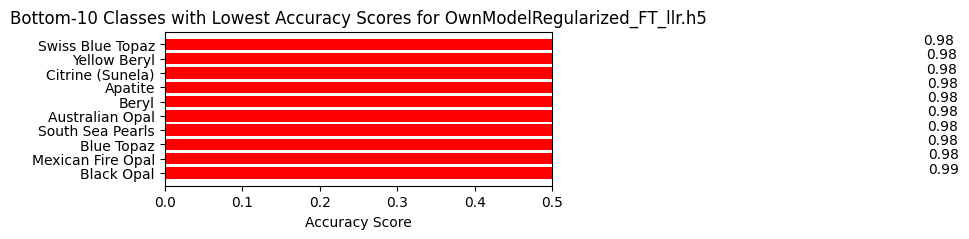

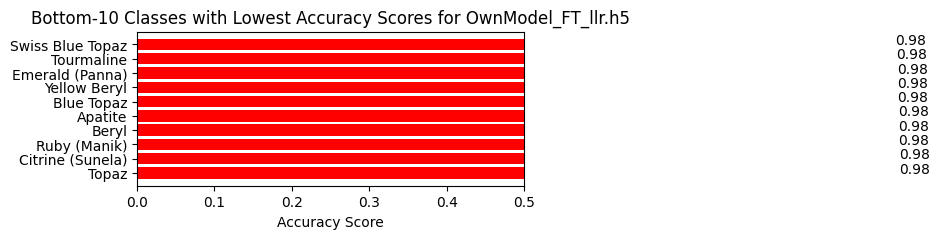

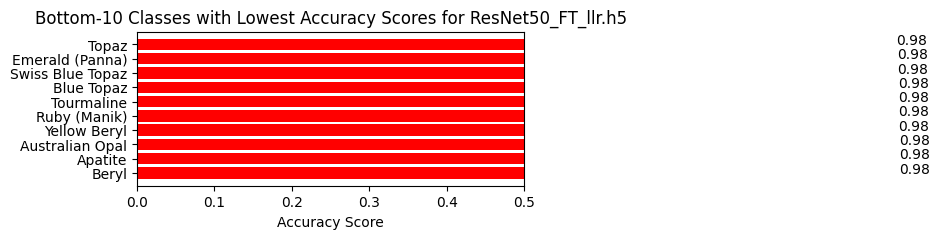

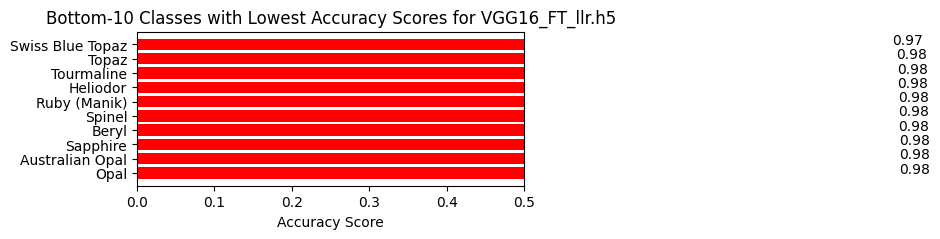

In [28]:
# Least-K Accuracy
for i, (model, result) in enumerate(results.items()):
    last_k_indices = np.argsort(result['accuracy'])[:k]
    last_k_ious = result['accuracy'][last_k_indices]
    last_k_class_names = [index_to_class[i] for i in last_k_indices]

    plt.figure(figsize=(5, 2))
    plt.barh(last_k_class_names, last_k_ious, color='red')
    # show the values on the bars
    for index, value in enumerate(last_k_ious):
        plt.text(value, index, f'{value:.2f}', ha='left', size=10)
    plt.xlabel('Accuracy Score')
    plt.xlim([0, 0.5])
    plt.title(f'Bottom-{k} Classes with Lowest Accuracy Scores for {model}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
    plt.show()    

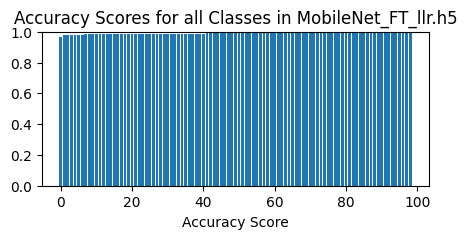

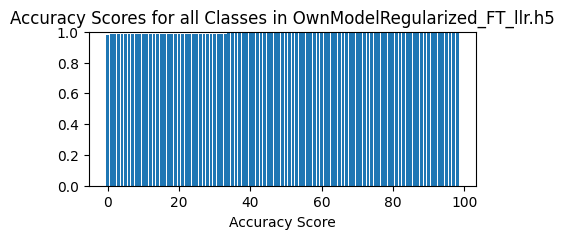

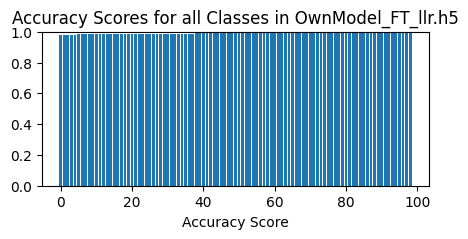

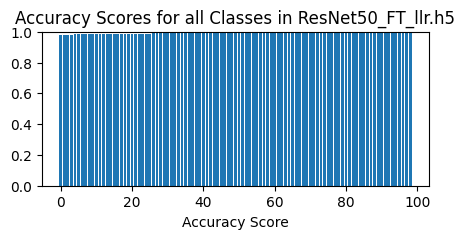

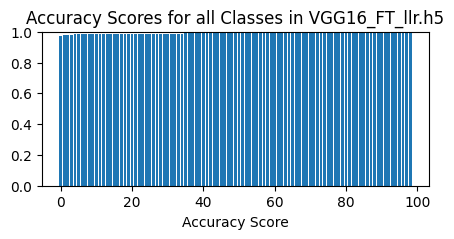

In [29]:
for i, (model, result) in enumerate(results.items()):
    plt.figure(figsize=(5, 2))
    plt.bar(list(range(len(result['accuracy']))), result['accuracy'][np.argsort(result['accuracy'])])
    plt.xlabel('Accuracy Score')
    plt.ylim([0, 1])
    plt.title(f'Accuracy Scores for all Classes in {model}')
    plt.show()

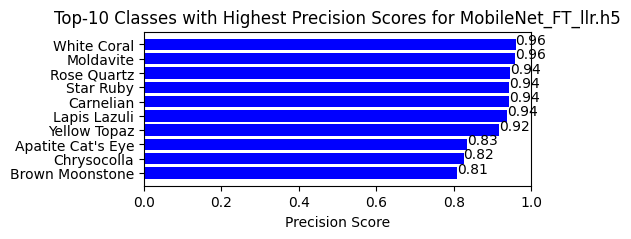

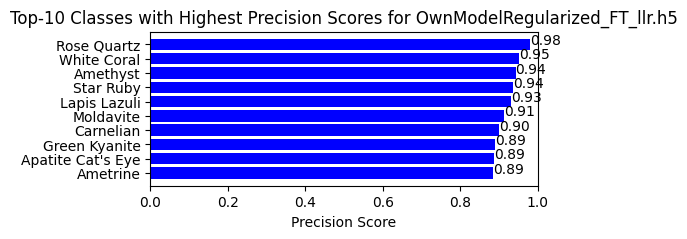

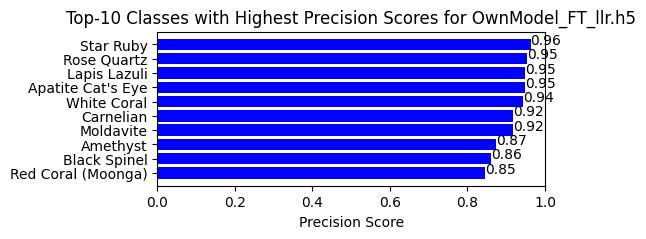

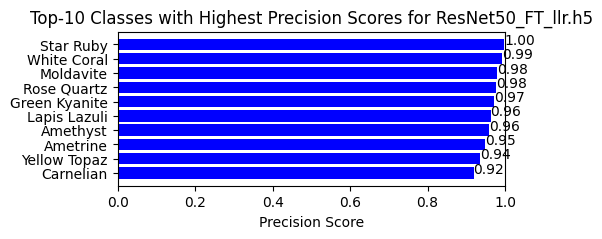

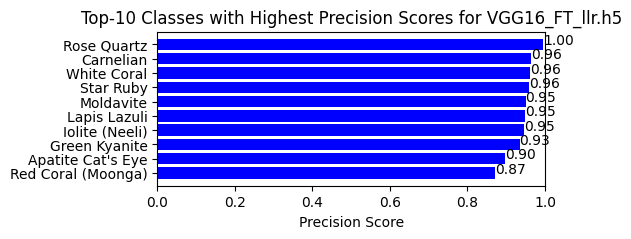

In [30]:
# Top-K Precision
for i, (model, result) in enumerate(results.items()):
    top_k_indices = np.argsort(result['precision'])[-k:][::-1]
    top_k_ious = result['precision'][top_k_indices]
    top_k_class_names = [index_to_class[i] for i in top_k_indices]
    plt.figure(figsize=(5, 2))
    plt.barh(top_k_class_names, top_k_ious, color='blue')
    # show the values on the bars
    for index, value in enumerate(top_k_ious):
        plt.text(value, index, f'{value:.2f}', ha='left', size=10)
    plt.xlabel('Precision Score')
    plt.xlim([0, 1])
    plt.title(f'Top-{k} Classes with Highest Precision Scores for {model}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
    plt.show()

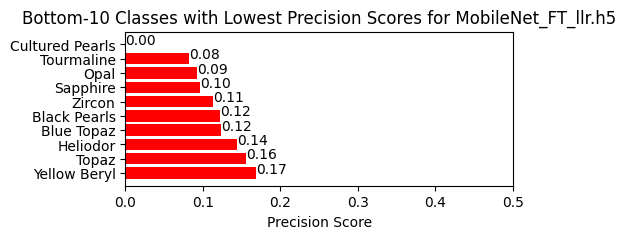

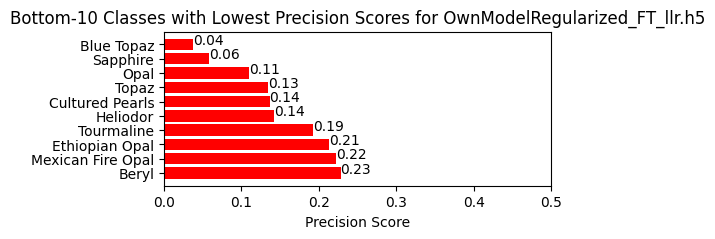

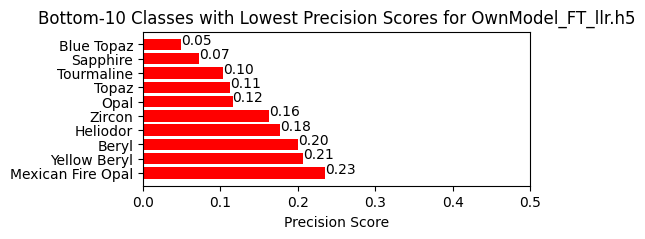

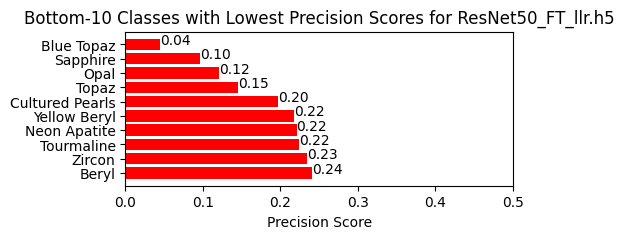

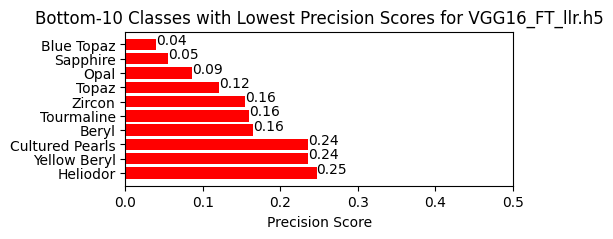

In [31]:
# Least-K Precision
for i, (model, result) in enumerate(results.items()):
    last_k_indices = np.argsort(result['precision'])[:k]
    last_k_ious = result['precision'][last_k_indices]
    last_k_class_names = [index_to_class[i] for i in last_k_indices]

    plt.figure(figsize=(5, 2))
    plt.barh(last_k_class_names, last_k_ious, color='red')
    # show the values on the bars
    for index, value in enumerate(last_k_ious):
        plt.text(value, index, f'{value:.2f}', ha='left', size=10)
    plt.xlabel('Precision Score')
    plt.xlim([0, 0.5])
    plt.title(f'Bottom-{k} Classes with Lowest Precision Scores for {model}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
    plt.show()    

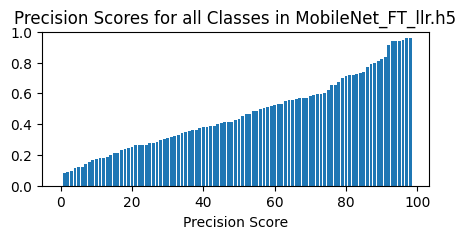

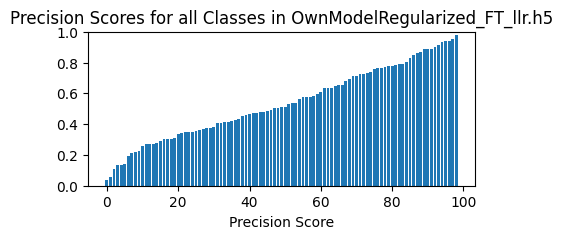

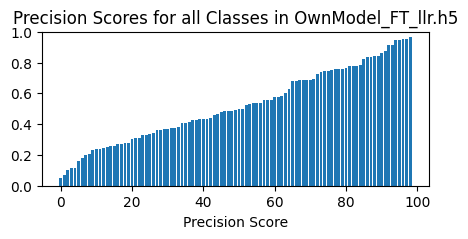

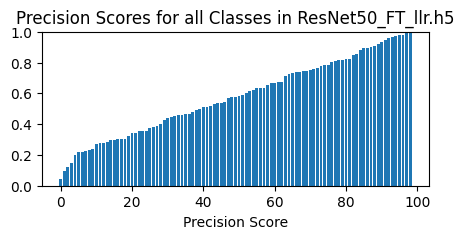

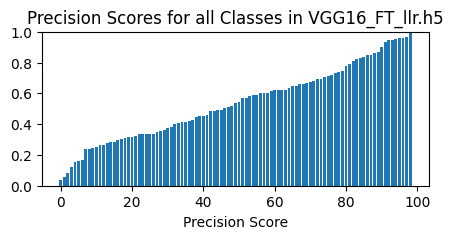

In [32]:
for i, (model, result) in enumerate(results.items()):
    plt.figure(figsize=(5, 2))
    plt.bar(list(range(len(result['precision']))), result['precision'][np.argsort(result['precision'])])
    plt.xlabel('Precision Score')
    plt.ylim([0, 1])
    plt.title(f'Precision Scores for all Classes in {model}')
    plt.show()

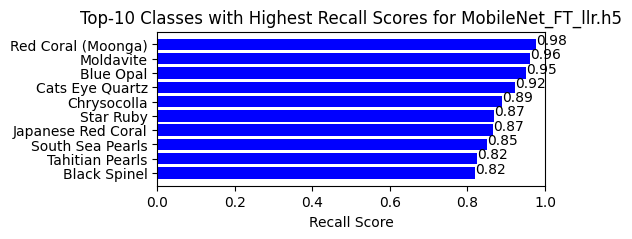

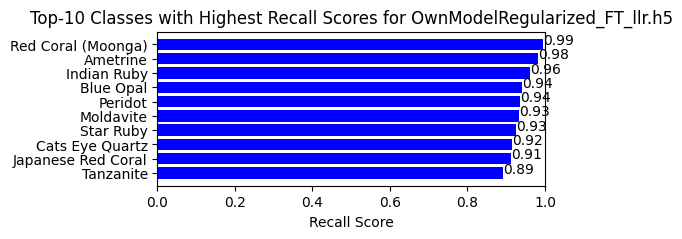

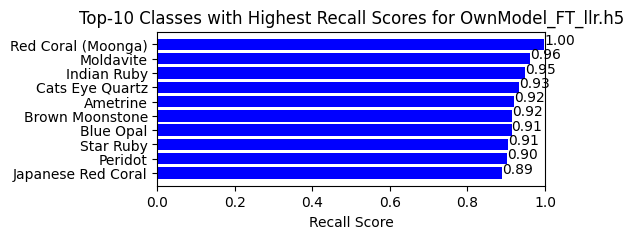

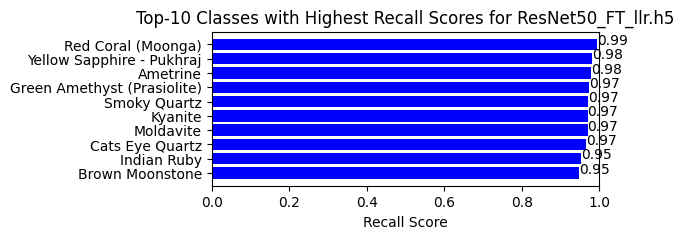

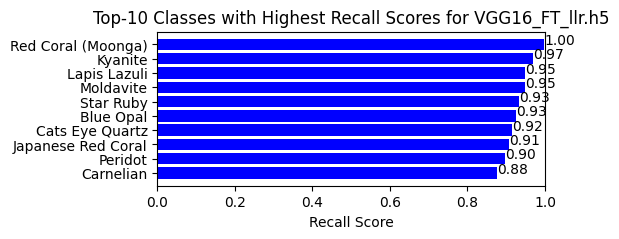

In [33]:
# Top-K Recall
for i, (model, result) in enumerate(results.items()):
    top_k_indices = np.argsort(result['recall'])[-k:][::-1]
    top_k_ious = result['recall'][top_k_indices]
    top_k_class_names = [index_to_class[i] for i in top_k_indices]
    plt.figure(figsize=(5, 2))
    plt.barh(top_k_class_names, top_k_ious, color='blue')
    # show the values on the bars
    for index, value in enumerate(top_k_ious):
        plt.text(value, index, f'{value:.2f}', ha='left', size=10)
    plt.xlabel('Recall Score')
    plt.xlim([0, 1])
    plt.title(f'Top-{k} Classes with Highest Recall Scores for {model}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
    plt.show()

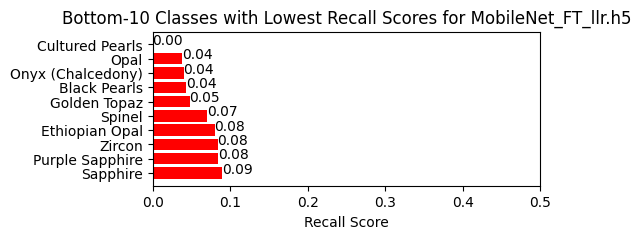

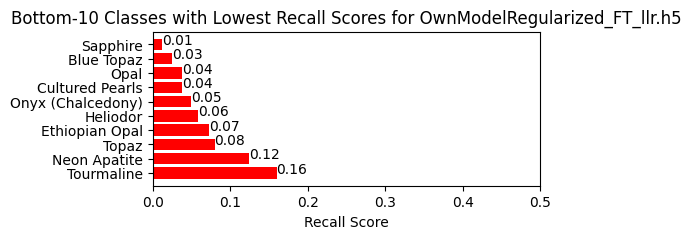

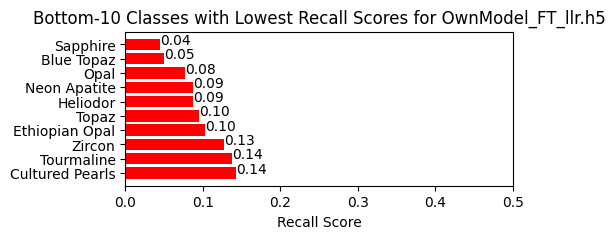

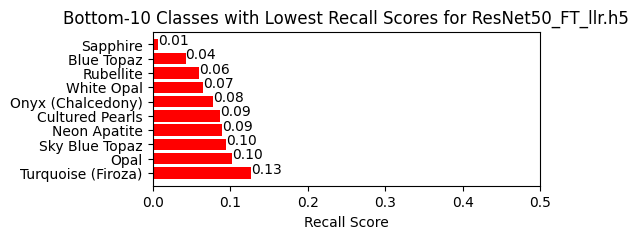

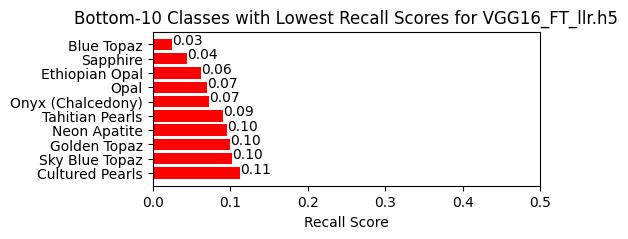

In [34]:
# Least-K Recall
for i, (model, result) in enumerate(results.items()):
    last_k_indices = np.argsort(result['recall'])[:k]
    last_k_ious = result['recall'][last_k_indices]
    last_k_class_names = [index_to_class[i] for i in last_k_indices]

    plt.figure(figsize=(5, 2))
    plt.barh(last_k_class_names, last_k_ious, color='red')
    # show the values on the bars
    for index, value in enumerate(last_k_ious):
        plt.text(value, index, f'{value:.2f}', ha='left', size=10)
    plt.xlabel('Recall Score')
    plt.xlim([0, 0.5])
    plt.title(f'Bottom-{k} Classes with Lowest Recall Scores for {model}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
    plt.show()    

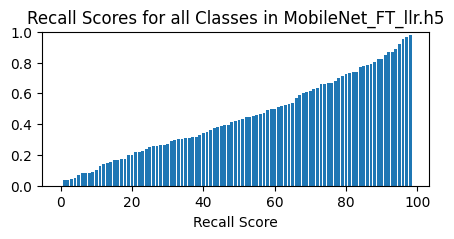

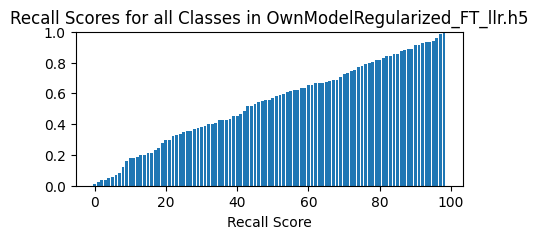

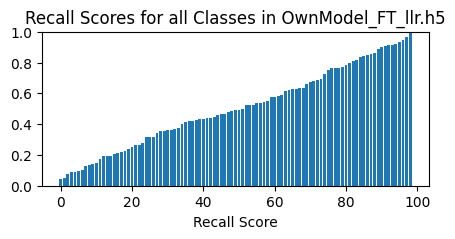

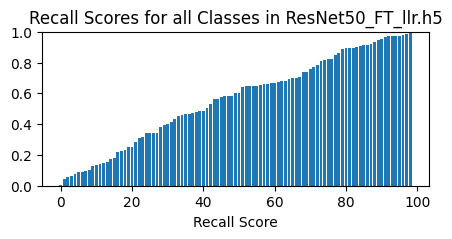

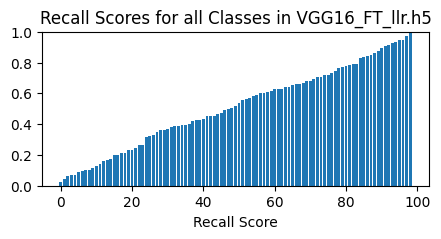

In [35]:
for i, (model, result) in enumerate(results.items()):
    plt.figure(figsize=(5, 2))
    plt.bar(list(range(len(result['recall']))), result['recall'][np.argsort(result['recall'])])
    plt.xlabel('Recall Score')
    plt.ylim([0, 1])
    plt.title(f'Recall Scores for all Classes in {model}')
    plt.show()

### What was misclassified as what?

In [38]:
from sklearn.metrics import confusion_matrix
import numpy as np

data_path = r'C:\Users\david\projects\University\gemstone-classifier\dat\gempundit_2022'
predicted_labels = results['OwnModelRegularized_FT_llr.h5']['predicted_labels']
last_k_indices = np.argsort(results['OwnModelRegularized_FT_llr.h5']['precision'])[:k]

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_labels)


for class_id in last_k_indices:
    class_row = cm[class_id, :].copy()
    class_row[class_id] = 0  # Zero out the diagonal
    
    number_of_misclassifications = np.sum(class_row)
    
    # Most common misclassification
    most_common_misclassified_as = np.argmax(class_row)
    most_common_count = class_row[most_common_misclassified_as]
    most_common_percentage_misclassified = round(most_common_count / number_of_misclassifications * 100, 1)
    
    # Second most common misclassification
    class_row[most_common_misclassified_as] = 0  # Zero out the most common
    second_most_common_misclassified_as = np.argmax(class_row)
    second_most_common_count = class_row[second_most_common_misclassified_as]
    second_most_common_percentage_misclassified = round(second_most_common_count / number_of_misclassifications * 100, 1)
    
    image_count = len(os.listdir(os.path.join(data_path, index_to_class[class_id])))
    
    # Print results 'CVN15J~1' is 'Natural Sapphire'
    print(f"Class '{index_to_class[class_id]}' misclassified {most_common_percentage_misclassified}% as '{index_to_class[most_common_misclassified_as]}' and {second_most_common_percentage_misclassified}% as '{index_to_class[second_most_common_misclassified_as]}'.")

Class 'Blue Topaz' misclassified 71.0% as 'Swiss Blue Topaz' and 7.9% as 'London Blue Topaz'.
Class 'Sapphire' misclassified 30.1% as 'CVN15J~1' and 22.3% as 'Blue Sapphire (Neelam)'.
Class 'Opal' misclassified 43.9% as 'Australian Opal' and 17.4% as 'Black Opal'.
Class 'Topaz' misclassified 57.9% as 'Swiss Blue Topaz' and 4.6% as 'London Blue Topaz'.
Class 'Cultured Pearls' misclassified 72.7% as 'South Sea Pearls' and 15.1% as 'Pearl (Moti)'.
Class 'Heliodor' misclassified 42.4% as 'Beryl' and 40.4% as 'Yellow Beryl'.
Class 'Tourmaline' misclassified 27.7% as 'Green Tourmaline (Verdelite)' and 9.5% as 'Alexandrite'.
Class 'Ethiopian Opal' misclassified 48.5% as 'Black Opal' and 16.7% as 'Opal'.
Class 'Mexican Fire Opal' misclassified 34.4% as 'Fire Opal' and 23.9% as 'Citrine (Sunela)'.
Class 'Beryl' misclassified 53.0% as 'Yellow Beryl' and 17.2% as 'Citrine (Sunela)'.
